In [1]:
import numpy as np
from matplotlib    import pyplot as plt
from numpy.random  import default_rng
from tqdm          import tqdm
from time          import perf_counter 
from scipy.stats   import rice, foldnorm
from dw_tools      import dag_pgm_tools, draw_tree
import networkx 
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import reciprocalspaceship as rs
import gemmi

In [2]:
plt.rcParams.update({'font.size': 14})
%load_ext autoreload
%autoreload 2

In [4]:
(r, rx, rt)   = (0.9, 0.95, 0.98)
node_labels   = ["Fref", "Foff", "Ft1s1", "Ft2s1", "Ft1s2", "Ft2s2", "Ft1s3", "Ft2s3"]
nodes         = range(len(node_labels))
root          = 0 # root of the tree
edges         = [(0,1),(1,2),(2,3),(1,4),(4,5),(1,6),(6,7)]
rdw           = [r,    rx,   rt,   rx,   rt,   rx,   rt   ] 
edge_labels   = [(node_labels[edges[e][0]], node_labels[edges[e][1]]) for e in range(len(edges))]

G=networkx.DiGraph()
G.add_nodes_from(node_labels)                            
G.add_edges_from(edge_labels)
print(f"Is this a valid tree? {networkx.is_arborescence(G)}.")

Is this a valid tree? True.


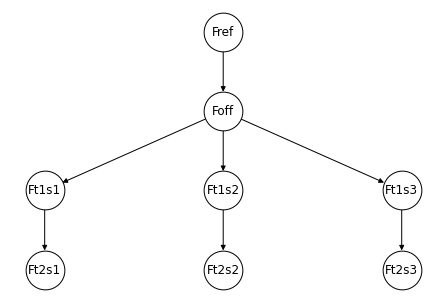

In [5]:
pos = graphviz_layout(G, prog="dot")
networkx.draw(G, pos, arrows=True,node_color='w', edgecolors='k',node_size=1500, with_labels = True)
plt.show()

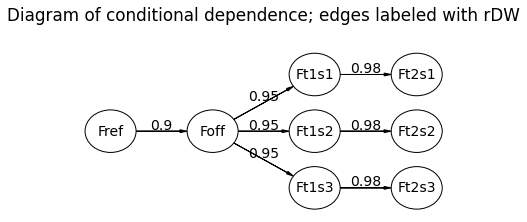

In [6]:
pgm = draw_tree.prepare_tree_pgm(nodes, edges, node_labels, rdw, root)
pgm.render()
plt.title(f"Diagram of conditional dependence; edges labeled with rDW\n")
plt.show()

So much for the fun...

In [9]:
# for this example, I worked out by hand the covariance matrix for the prior:
Sig_full = [[1,r,r*rx,r*rx*rt,r*rx,r*rx*rt,r*rx,r*rx*rt],\
            [r,1,rx,rx*rt,rx,rx*rt,rx,rx*rt],\
            [rx*r,rx,1,rt,rx*rx,rx*rx*rt,rx*rx,rx*rx*rt],\
            [rt*rx*r,rt*rx,rt,1,rt*rx*rx,rt*rx*rx*rt,rt*rx*rx,rt*rx*rx*rt],\
            [rx*r,rx,rx*rx,rx*rx*rt,1,rt,rx*rx,rx*rx*rt],\
            [rt*rx*r,rt*rx,rt*rx*rx,rt*rx*rx*rt,rt,1,rt*rx*rx,rt*rx*rx*rt],\
            [rx*r,rx,rx*rx,rx*rx*rt,rx*rx,rx*rx*rt,1,rt],\
            [rt*rx*r,rt*rx,rt*rx*rx,rt*rx*rx*rt,rt*rx*rx,rt*rx*rx*rt,rt,1]
           ]
Sig_full = 0.5*np.array(Sig_full)

In [ ]:
def Cov_from_DAG_prior_acentric(list_of_nodes, list_of_edges, list_of_rdw, mu_per_node=0, Sigma=1, as_block=True):
    '''
    Calculating the covariance of the JPD of a directed acyclic graph of acentric structure factors.
    This implements Murphy, eqs. 10.15-10.22
    Input arguments:
    list_of_nodes : List of indices of nodes to be used in calculating the JPD
    list_of_edges : List of tuples (from, to) summarizing conditional dependencies
    list_of_rdw   : List of double-wilson parameters (floats) corresponding to each edge
    mu_per_node   : List of floats; unconditional expectation values for each node (default: 0)
    Sigma         : Float, default expectation value <F**2> (Default: 1)
    as_block      : Boolean; whether to return a block matrix with covariances for real and 
                    imaginary components (Default: True).
    '''
    n_nodes = len(list_of_nodes)
    n_edges = len(list_of_edges)

    W = np.zeros((n_nodes, n_nodes))
    S = np.zeros((n_nodes, n_nodes))
    for i in range(n_edges):
        W[list_of_edges[i][1], list_of_edges[i][0]] = list_of_rdw[i]

    S[0,0]=np.sqrt(0.5*Sigma) # this is not explicit in Murphy but essential
    for i in range(n_edges):
        S[list_of_edges[i][1],list_of_edges[i][1]] = np.sqrt(0.5*(1-list_of_rdw[i]**2))

    U = np.linalg.inv(np.eye(n_nodes)-W)
    Sig_DAG = np.matmul(np.matmul(U,S),np.transpose(np.matmul(U,S)))
    
    if as_block:
        return np.block([[Sig_DAG,np.zeros((n_nodes,n_nodes))],[np.zeros((n_nodes,n_nodes)),Sig_DAG]])
    else:
        return Sig_DAG

def Cov_from_DAG_prior_centric( list_of_nodes, list_of_edges, list_of_rdw, mu_per_node=0, Sigma=1):
    '''
    Calculating the covariance of the JPD of a directed acyclic graph of acentric structure factors.
    This implements Murphy, eqs. 10.15-10.22
    Input arguments:
    list_of_nodes : List of indices of nodes to be used in calculating the JPD
    list_of_edges : List of tuples (from, to) summarizing conditional dependencies
    list_of_rdw   : List of double-wilson parameters (floats) corresponding to each edge
    mu_per_node   : List of floats; unconditional expectation values for each node (default: 0)
    Sigma         : Float, default expectation value <F**2> (Default: 1)
    '''
    return Cov_from_DAG_acentric(list_of_nodes, list_of_edges, list_of_rdw, mu_per_node, Sigma=2*Sigma, as_block=False)

Generic surrogate posterior:

In [30]:
def Cov_from_DAG_surrogate_acentric(nodes, edges, sig_x, sig_y, r_x=0, r_y=0):
    '''
    Calculating the covariance of the JPD of a directed acyclic graph of acentric structure factors.
    This implements Murphy, eqs. 10.15-10.22. This function assumes a single root node with index 0.
    Input arguments:
    nodes : List of indices of nodes to be used in calculating the JPD
    edges : List of tuples (from, to) summarizing conditional dependencies
    sig_x : List of scale parameters for the real components for each node
    sig_y : List of scale parameters for the imag components for each node
    r_x   : List of posterior correlation parameters (floats) for real components for each edge; 
    r_y   : List of posterior correlation parameters (floats) for imag components for each edge; 
            *do not include r_x=r_y=0 for the root*.
    '''
    n_nodes = len(nodes)
    n_edges = len(edges)

    W = np.zeros((2*n_nodes, 2*n_nodes))
    for i in range(n_edges):
        # correlations for real & imag components
        W[        edges[i][1],         edges[i][0]] = r_x[i] # see below eq 10.15 in Murphy
        W[n_nodes+edges[i][1], n_nodes+edges[i][0]] = r_y[i]
    
    S = np.diag(sig_x + sig_y) # note that + here indicates list concatenation
    
    U = np.linalg.inv(np.eye(2*n_nodes)-W)
    Sig_DAG = np.matmul(np.matmul(U,S),np.transpose(np.matmul(U,S)))
    
    return Sig_DAG

def Cov_from_DAG_surrogate_centric(nodes, edges, sig, rdw=0):
    '''
    Calculating the covariance of the JPD of a directed acyclic graph of acentric structure factors.
    This implements Murphy, eqs. 10.15-10.22. This function assumes a single root node with index 0.
    Input arguments:
    nodes : List of indices of nodes to be used in calculating the JPD
    edges : List of tuples (from, to) summarizing conditional dependencies
    sig   : List of scale parameters for the real components for each node
    rdw   : List of posterior correlation parameters (floats) for real components for each node; 
            *do not include r=0 for the root*.
    '''
    n_nodes = len(nodes)
    n_edges = len(edges)

    W = np.zeros((n_nodes, n_nodes))
    for i in range(n_edges):
        W[list_of_edges[i][1], list_of_edges[i][0]] = rdw[i]

    S = np.diag(sig) 
    
    U = np.linalg.inv(np.eye(n_nodes)-W)
    Sig_DAG = np.matmul(np.matmul(U,S),np.transpose(np.matmul(U,S)))
    return Sig_DAG